# Spray Glider - Spatial Scales Analysis  

**Purpose**: Code for computing the autocorrelation function along a spray glider transect

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
from scipy.interpolate import interp1d

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, decor_scale
from lsf import detrend

Set data analysis parameters

In [3]:
years_d      = ['2023']    # Year(s) to analyze 

Load spray glider and intermediate data products (**NOTE**:  The intermediate data have the same profile coordinate as the spray glider data and have the same mask as the longitude and latitude from the spray glider data)

In [4]:
# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"

#--- Spray Glider Data ---# 
filename_sg = PATH + "/data/spray_gliders/CUGN_line_80.nc"
nc = Dataset(filename_sg, 'r')

# Extract data variables
profile = nc.variables['profile'][:]
depth   = nc.variables['depth'][:]

lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
lon_uv = nc.variables['lon_uv'][:]
lat_uv = nc.variables['lat_uv'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)
time_uv =  num2date(nc.variables['time_uv'][:], nc.variables['time_uv'].units)

temperature = nc.variables['temperature'][:]
salinity = nc.variables['salinity'][:]
chla = nc.variables['chlorophyll_a'][:]
doxy = nc.variables['doxy'][:]
u = nc.variables['u'][:]
v = nc.variables['v'][:]

#--- Intermediate Data ---# 
filename_int = PATH + "/data/spray_gliders/CUGN_line_80_intermediate_data.nc"
nc = Dataset(filename_int, 'r')

# Extract data variables
dist = nc.variables['DIST'][:]
dist_uv   = nc.variables['DIST_uv'][:]
water_depth = nc.variables['WATER_DEPTH'][:]
water_depth_uv   = nc.variables['WATER_DEPTH_uv'][:]

/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


Now grab temperature data from multiple years and at a single depth

In [5]:
# Grab temperature, salinity, horizontal velocities from a given depth 
#--- Single Depth ---#
depth_bin = depth[0]
temperature_dp = temperature[depth == depth_bin,:].T.squeeze()
#--- Depth averaged ---#
#depth_bin = depth[-2]
#temperature_dp = np.ma.mean(temperature[(depth >= depth[0]) & (depth <= depth_bin),:].T,axis=1)

# Grab indices of masked elements 
time_mask = np.array(np.where(time.mask))
lon_mask  = np.array(np.where(lon.mask))
lat_mask  = np.array(np.where(lat.mask))

# Check if the masked elements in time, lon, and lat 
if (time_mask == lon_mask).all() and (time_mask == lat_mask).all() and (lon_mask == lat_mask).all():

    # Combine masks from time and temperature 
    temp_mask = np.logical_or(temperature_dp.mask,time.mask)

    # Mask temperature, time, lon, and lat on the new mask 
    temp_m = np.ma.masked_where(temp_mask,temperature_dp)
    time_m = np.ma.masked_where(temp_mask,time)
    lon_m  = np.ma.masked_where(temp_mask,lon)
    lat_m  = np.ma.masked_where(temp_mask,lat)
    dist_m = np.ma.masked_where(temp_mask,dist)
    water_depth_m = np.ma.masked_where(temp_mask,water_depth)

    # Removed Masked values 
    temp_m_cn = temp_m.compressed()
    time_m_cn = time_m.compressed()
    lon_m_cn  = lon_m.compressed()
    lat_m_cn  = lat_m.compressed()
    dist_m_cn   = dist_m.compressed()
    water_depth_m_cn = water_depth_m.compressed()

    # Grab the years from the cleaned time array 
    years  = np.array([y.year for y in time_m_cn])

    # Initialize year array 
    temp_t = []
    time_t = []
    lon_t = []
    lat_t = []
    dist_t = []
    water_depth_t = []

    # Loop through years 
    for iyear in range(0,len(years_d)):

        # Find indices for ith year
        year_idx = years == int(years_d[iyear]) 

        # Obtain time steps from ith year
        temp_t.extend(temp_m_cn[year_idx])
        time_t.extend(time_m_cn[year_idx])
        lon_t.extend(lon_m_cn[year_idx])
        lat_t.extend(lat_m_cn[year_idx])
        dist_t.extend(dist_m_cn[year_idx])
        water_depth_t.extend(water_depth_m_cn[year_idx])

# Convert variables to numpy arrays 
temp_t        = np.array(temp_t)
time_t        = np.array(time_t)
lon_t         = np.array(lon_t)
lat_t         = np.array(lat_t)
dist_t        = np.array(dist_t)
water_depth_t = np.array(water_depth_t)

Compute the distance from the shore relative to Point Conception 

In [6]:
point_pc = (34.4488552,-120.457673)
point_sb = (34.23,-121.3)
distance_sb = geodesic(point_sb, point_pc).kilometers

Convert cftime.DatetimeGregorian to Python datetime objects

In [7]:
time_dt = [datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_t]

Grab a spray single transect  

In [8]:
# Set indices 
idx_i, idx_f = 100, 318 #440, 539 #318, 440
transNum     = 1

# Grab transect
time_trans = time_dt[idx_i:idx_f]
dist_trans = dist_t[idx_i:idx_f]
water_depth_trans = water_depth[idx_i:idx_f]
temp_trans = temp_t[idx_i:idx_f]

Plot the trajectory of the glider transect

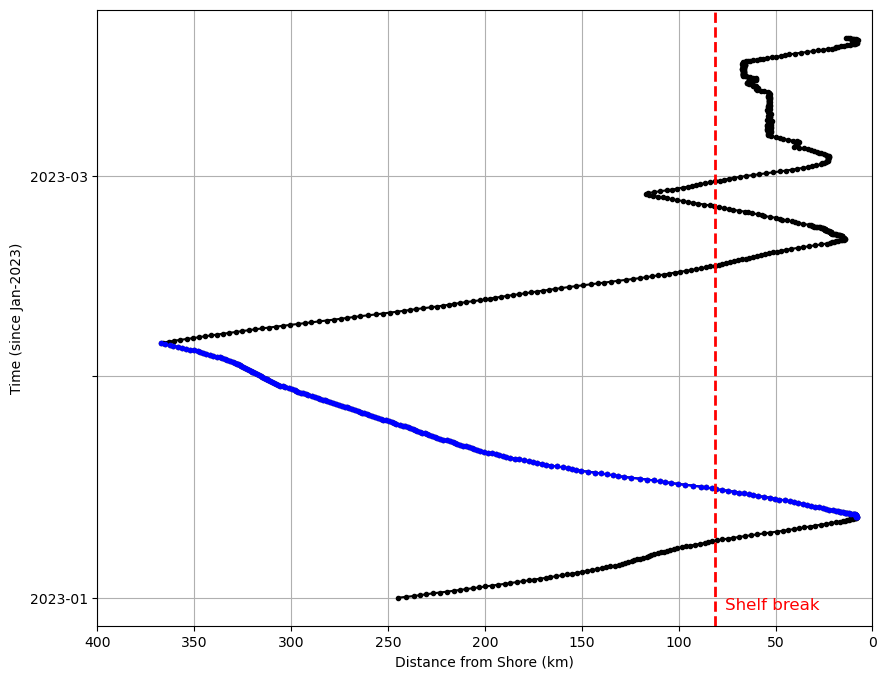

In [9]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot the 
plt.plot(dist_t[0:800],time_dt[0:800],'k.-') # [0:800]
plt.plot(dist_trans,time_trans,'b.-')

# Plot the distance of the shelf break from the shore
plt.axvline(x=distance_sb, color='r', linestyle='--', linewidth=2, label='Vertical Line')

# Set axis attributes
axes.set_xlabel(r"Distance from Shore (km)")
axes.set_ylabel(r"Time (since Jan-" + years_d[0] + ")")
axes.set_xlim(0, 400)
axes.grid()

# Add label text near the vertical line
plt.text(distance_sb-5,time_dt[0], r'Shelf break', color='r', fontsize=12, ha='left',va='top',rotation=0)

# Set time axis tickmarks
plt.gca().yaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Get the current tick labels
ticks = plt.gca().get_yticklabels()

# Hide every other tick label (e.g., hide even indexed ones)
for i, tick in enumerate(ticks):
    if i % 2 != 0:  # Hide every other tick (i.e., odd indexed ticks)
        tick.set_visible(False)

# Reverse the direction of the x-axis 
plt.gca().invert_xaxis()

# Display figure
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/transect_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

Bin the temperature data onto a regular spatial grid 

In [10]:
# Compute the mean distance between profiles 
mean_dist_diff = 2 #int(np.round(np.ma.mean(abs(np.ma.diff(dist_trans)))))

# Generate a new distance 
dist_edges = np.arange(dist_trans[0],dist_trans[-1] + mean_dist_diff, mean_dist_diff)  # Bin edges 
dist_bin = dist_edges[:-1] + np.diff(dist_edges)/2  # Bin centers 

# Create a pandas DataFrame
df = pd.DataFrame({'distance': dist_trans, 'temperature': temp_trans, 'water_depth': water_depth_trans})

# Assign each data point to a bin
df['bin'] = pd.cut(df['distance'], bins=dist_edges, labels=dist_bin, include_lowest=True)

# Compute bin-averaged temperature and water depth
binned_data = df.groupby('bin').agg(
    mean_temperature=('temperature', 'mean'),
    std_temperature=('temperature', 'std'),
    mean_water_depth=('water_depth', 'mean'),
    std_water_depth=('water_depth', 'std'),
    count=('temperature', 'count')  
).reset_index()

# Extract data from dataframe and mask NaNs 
temp_bin = np.ma.masked_invalid(binned_data['mean_temperature'].values)
water_depth_bin = np.ma.masked_invalid(binned_data['mean_water_depth'].values)
counts = np.ma.masked_invalid(binned_data['count'].values)

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_4832/4244158679.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby('bin').agg(


Split into on-shelf and off-shelf regions while preserving masked values 

**On-shelf**

In [11]:
# Fill masked values with 9999 (for preserving masked elements in the array when indexing for on-shelf case)
water_depth_bin_fill = np.array(water_depth_bin.filled(9999))

# Find the indices for on-shelf 
on_lim = -1000 #-800
idx_on = water_depth_bin_fill >= on_lim

# Grab distance, temp, and water depth from binned data
dist_on_fill = dist_bin[idx_on]
temp_on_fill = temp_bin[idx_on]
water_depth_on_fill = water_depth_bin_fill[idx_on]

#--- Remove any fill values at the end of the record ---# 

# Find the indices of all the filled values and take their difference
idx_fill = np.where(water_depth_on_fill == 9999)[0]
idx_fill_diff = np.diff(idx_fill)

# Find the index of the last one in the sequence if masked values are present in the record
if len(idx_fill_diff) == 0:

    # Set distance, temperature, and water depth to un-indexed variables when no masked values are present
    dist_on = dist_on_fill
    temp_on = temp_on_fill
    water_depth_on_fill_trim = water_depth_on_fill

elif len(idx_fill_diff) != 0:

    #--- If no fill values at the end of the record ---# 
    if idx_fill_diff[-1] != 1:

        # Set index to 0
        idx_one = -1 

    #--- If fill values do exist at the end of the record ---# 
    else:
        idx_one = len(idx_fill_diff) - np.argmax(idx_fill_diff[::-1] != 1)

    # Remove fill values at the beginning 
    dist_on = dist_on_fill[:idx_fill[idx_one]]
    temp_on = temp_on_fill[:idx_fill[idx_one]]
    water_depth_on_fill_trim = water_depth_on_fill[:idx_fill[idx_one]]

# Replace rest of the filled values with masks (for preserving masked elements in the array)
water_depth_on = np.ma.masked_equal(water_depth_on_fill_trim, 9999)

**Off-shelf**

In [12]:
# Fill masked values with -9999 (for preserving masked elements in the array when indexing for off-shelf)
water_depth_bin_fill = np.array(water_depth_bin.filled(-9999))

# Find the indices for off and on shelf 
off_lim = -3000 #-2000
idx_off = water_depth_bin_fill <= off_lim

# Grab distance, temp, and water depth from binned data
dist_off_fill = dist_bin[idx_off]
temp_off_fill = temp_bin[idx_off]
water_depth_off_fill = water_depth_bin_fill[idx_off]

#--- Remove any fill values at the beginning of the record ---#

# Find the indices of all the filled values and take their difference
idx_fill = np.diff(np.where(water_depth_off_fill == -9999))[0]

# Find the index of the last one in the sequence if masked values are present in the record
if len(idx_fill) == 0:

    # Set distance, temperature, and water depth to un-indexed variables when no masked values are present
    dist_off = dist_off_fill
    temp_off = temp_off_fill
    water_depth_off_fill_trim = water_depth_off_fill

elif len(idx_fill) != 0:

    #--- If no fill values at the beginning of the record ---# 
    if idx_fill[0] != 1:

        # Set index to 0
        idx_one = 0  

    #--- If fill values do exist at the beginning of the record ---# 
    else:
        idx_one = np.argmax(idx_fill != 1) - 1 if np.any(idx_fill != 1) else len(idx_fill) - 1

    # Remove fill values at the beginning 
    dist_off = dist_off_fill[idx_one + 2:]
    temp_off = temp_off_fill[idx_one + 2:]
    water_depth_off_fill_trim = water_depth_off_fill[idx_one + 2:]

# Replace rest of the filled values with masks (for preserving masked elements in the array)
water_depth_off = np.ma.masked_equal(water_depth_off_fill_trim, -9999)

Detrend temperature record 

In [13]:
temp_on_dt = detrend(temp_on) - np.ma.mean(temp_on)
temp_off_dt = detrend(temp_off) - np.ma.mean(temp_off)

Compute autocorrelation functions 

In [14]:
#--- On Shelf ---# 

# Set parameters
window_on = len(temp_on_dt)
lag_on = len(temp_on_dt)
task = 'full'
bias = 'biased' #'unbiased_tapered'

# Compute autocorrelation function
coef_pos_on, coef_neg_on, _, _, countPairs_m_on, countPairs_nm_on = compute_autocorr(temp_on_dt, window_on, lag_on, task, bias)

# Compute decorrelation time scale 
_, tau_on = decor_scale(temp_on_dt, mean_dist_diff)

# Add back in the mean 
temp_on_dt +=  np.mean(temp_on)

#--- Off Shelf ---# 

# Set parameters
window_off = len(temp_off_dt)
lag_off = len(temp_off_dt)

# Compute autocorrelation function
coef_pos_off, coef_neg_off, _, _, countPairs_m_off, countPairs_nm_off = compute_autocorr(temp_off_dt, window_off, lag_off, task, bias)

# Compute decorrelation time scale 
_, tau_off = decor_scale(temp_off_dt, mean_dist_diff)

# Add back in the mean 
temp_off_dt +=  np.mean(temp_off)

Plot data processing, on/off shelf regimes and the on-shelf and off-shelf autocorrelation functions

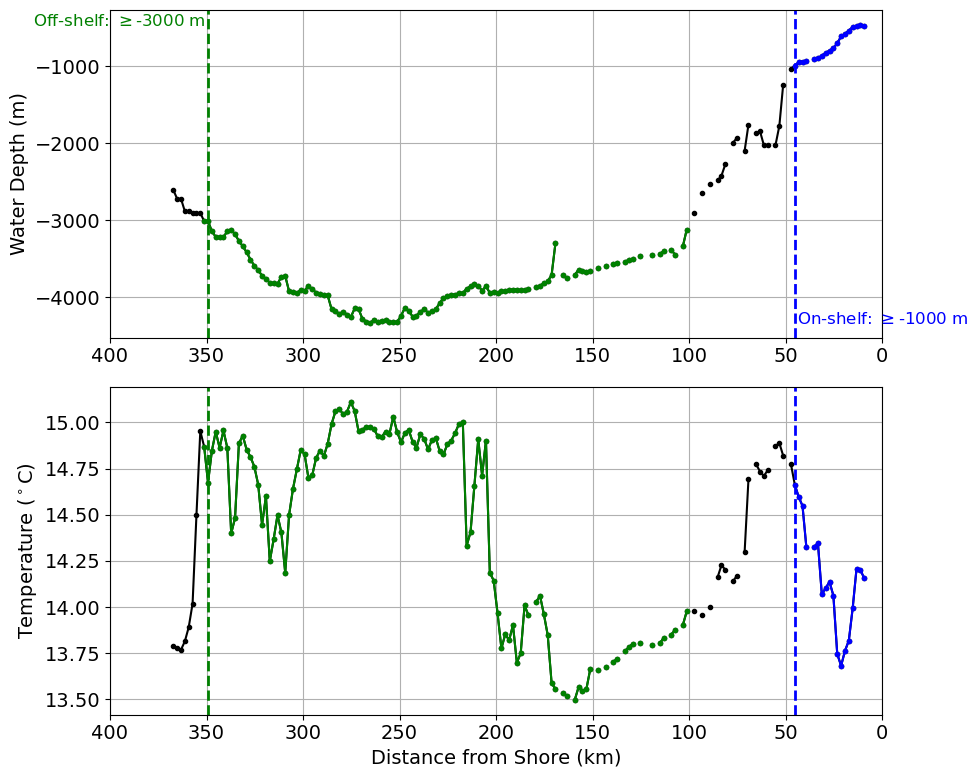

In [15]:
# Obtain the distance from shore of the on and off-shelf depth criteria 
idx_on = np.abs(water_depth_bin - on_lim).argmin()
idx_off = np.abs(water_depth_bin - off_lim).argmin()
dist_on_lim = dist_bin[idx_on]
dist_off_lim = dist_bin[idx_off]

# Set plotting parameters
fontsize = 14
plt.rcParams.update({'font.size': fontsize})  # Change 14 to any desired size
plt.rcParams['text.usetex'] = False

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

#--- Suplot #1 ---# 

# Plot water depth and on/off-shelf regions
axes[0].plot(dist_bin,water_depth_bin,'k.-')
axes[0].plot(dist_on,water_depth_on,'b.-')
axes[0].plot(dist_off,water_depth_off,'g.-')

# Plot on and off-shelf limits
axes[0].axvline(dist_on_lim, color='b', linestyle='--', linewidth=2)
axes[0].axvline(dist_off_lim, color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
axes[0].text(dist_on_lim - 1,np.min(water_depth_bin)+150, r'On-shelf: $\geq$' + str(on_lim) + ' m', color='b', fontsize=12, ha='left',va='top',rotation=0)
axes[0].text(dist_off_lim + 1,np.max(water_depth_bin)+150, r'Off-shelf: $\geq$' + str(off_lim) + ' m', color='g', fontsize=12, ha='right',va='top',rotation=0)

# Set axis attributes
#axes[0].set_xlabel(r"Distance from Shore (km)")
axes[0].set_ylabel(r"Water Depth (m)")
axes[0].set_xlim(0,400)
#axes[0].set_ylim(-4000,0)
axes[0].grid()

# Reverse the direction of the x-axis 
axes[0].invert_xaxis()

#--- Suplot #2 ---# 

# Plot temperature and on/off-shelf regions
axes[1].plot(dist_bin,temp_bin,'k.-')
axes[1].plot(dist_on,temp_on,'b.-')
axes[1].plot(dist_off,temp_off,'g.-')

# Plot on and off-shelf limits
axes[1].axvline(dist_on_lim, color='b', linestyle='--', linewidth=2)
axes[1].axvline(dist_off_lim, color='g', linestyle='--', linewidth=2)

# Set axis attributes
axes[1].set_xlabel(r"Distance from Shore (km)")
axes[1].set_ylabel(r"Temperature ($^\circ$C)")
axes[1].set_xlim(0,400)
#axes[1].set_ylim(11.25,13)
axes[1].grid()

# Reverse the direction of the x-axis 
axes[1].invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/onshelf_offshelf_regimes_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_binWidth_' + str(mean_dist_diff) + 'km' + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

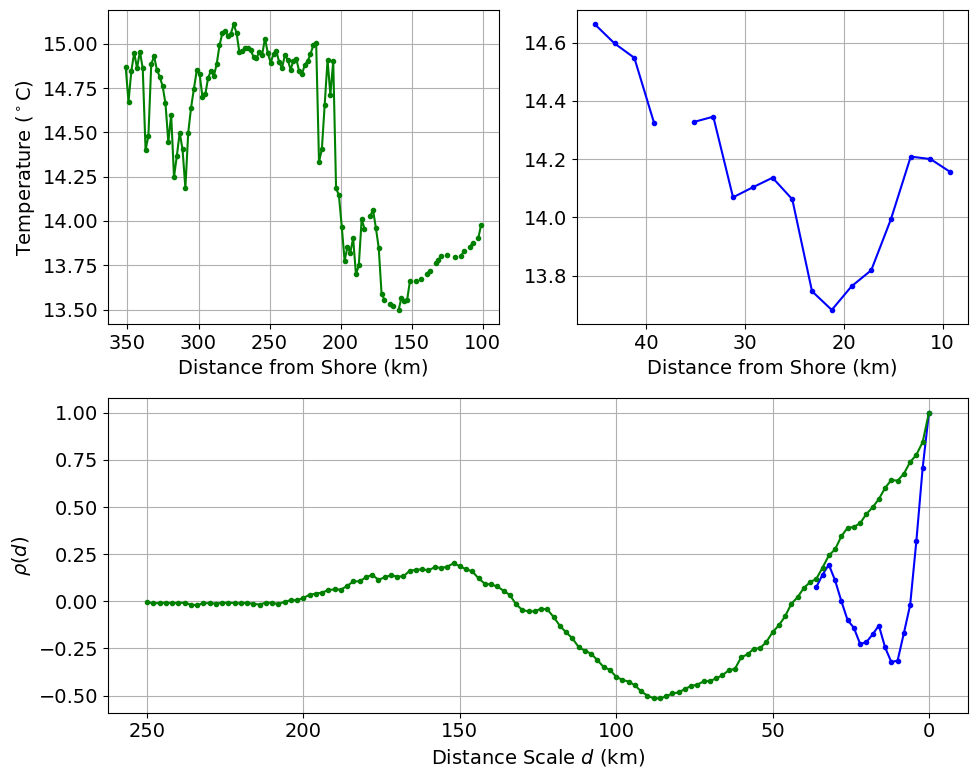

In [16]:
# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#--- Suplot #1 ---# 

# Plot off-shelf temperature 
axes[0,0].plot(dist_off,temp_off,'g.-')

# Set axis attributes
axes[0,0].set_xlabel(r"Distance from Shore (km)")
axes[0,0].set_ylabel(r"Temperature ($^\circ$C)")
#axes[0,0].set_xlim(75,120)
#axes[0,0].set_ylim(11.8,13)
axes[0,0].grid()

# Reverse the direction of the x-axis 
axes[0,0].invert_xaxis()

#--- Suplot #2 ---# 

# Plot on-shelf temperature 
axes[0,1].plot(dist_on,temp_on,'b.-')

# Set axis attributes
axes[0,1].set_xlabel(r"Distance from Shore (km)")
#axes[0,1].set_xlim(13,26)
#axes[0,1].set_ylim(12.5,13)
axes[0,1].grid()

# Reverse the direction of the x-axis 
axes[0,1].invert_xaxis()

# Remove the bottom two individual subplots
for ax in axes[1, :]:  
    ax.remove()  # Remove existing subplots

# Create a new bottom subplot spanning two columns
ax_bottom = fig.add_subplot(2, 1, 2)  # Row 2, full width

#--- Suplot #3 ---#

# Plot autocorrelation functions
ax_bottom.plot(dist_on-dist_on[0],coef_pos_on,'b.-')
ax_bottom.plot(dist_off-dist_off[0],coef_pos_off,'g.-')

# Set axis attributes
ax_bottom.set_xlabel(r"Distance Scale $d$ (km)")
ax_bottom.set_ylabel(r"$\rho(d)$")
#ax_bottom.set_xlim(0,42)
#ax_bottom.set_ylim(-0.5,1)
ax_bottom.grid()

# Reverse the direction of the x-axis 
ax_bottom.invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/onshelf_offshelf_autocorr_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_binWidth_' + str(mean_dist_diff) + 'km' + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

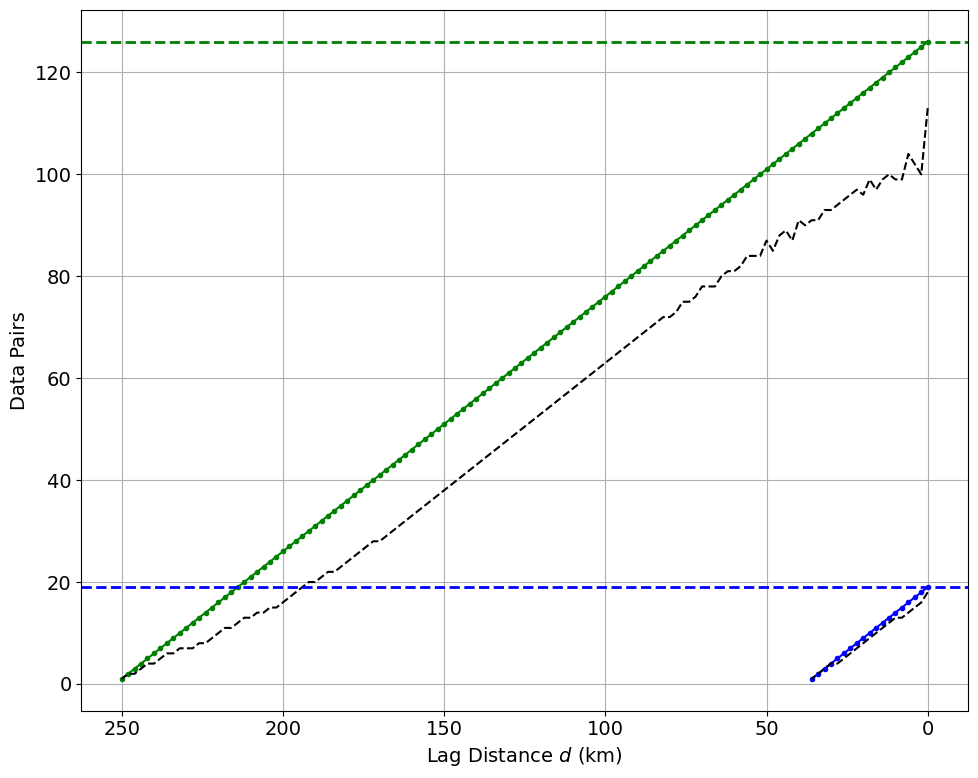

In [17]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot autocorrelation functions
axes.plot(dist_on-dist_on[0],countPairs_m_on,'b.-')
axes.plot(dist_off-dist_off[0],countPairs_m_off,'g.-')
axes.plot(dist_on-dist_on[0],countPairs_nm_on,'k--')
axes.plot(dist_off-dist_off[0],countPairs_nm_off,'k--')

# Plot on and off-shelf limits
axes.axhline(window_on, color='b', linestyle='--', linewidth=2)
axes.axhline(window_off, color='g', linestyle='--', linewidth=2)

# Set axis attributes
axes.set_xlabel(r"Lag Distance $d$ (km)")
axes.set_ylabel(r"Data Pairs")
#axes.set_xlim(0,42)
#axes.set_ylim(-0.5,1)
axes.grid()

# Reverse the direction of the x-axis 
axes.invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

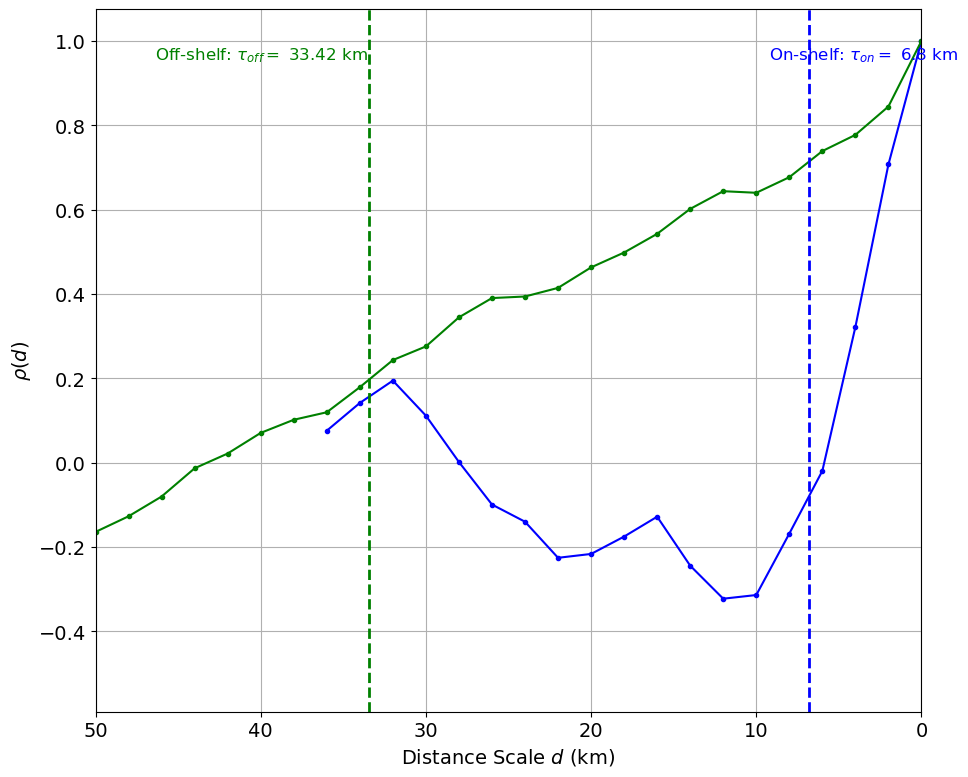

In [18]:
# Create figure
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

# Plot a zoomed in view of the autocorrelation function
axes.plot(dist_on-dist_on[0],coef_pos_on,'b.-')
axes.plot(dist_off-dist_off[0],coef_pos_off,'g.-')

# Plot the decorrelation scales 
axes.axvline(tau_on, color='b', linestyle='--', linewidth=2)
axes.axvline(tau_off, color='g', linestyle='--', linewidth=2)

# Add label text near the vertical lines
axes.text(tau_on + 2.4,np.max(coef_pos_on) - 0.01, r'On-shelf: $\tau_{on} =$ ' + str(np.round(tau_on,2)) + ' km', color='b', fontsize=12, ha='left',va='top',rotation=0)
axes.text(tau_off + 0.1,np.max(coef_pos_off) - 0.01, r'Off-shelf: $\tau_{off} =$ ' + str(np.round(tau_off,2)) + ' km', color='g', fontsize=12, ha='right',va='top',rotation=0)

# Set axis attributes
axes.set_xlabel(r"Distance Scale $d$ (km)")
axes.set_ylabel(r"$\rho(d)$")
axes.set_xlim(0,50)
#axes.set_ylim(-0.5,1)
axes.grid()

# Reverse the direction of the x-axis 
axes.invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/onshelf_offshelf_autocorr_zoom_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_binWidth_' + str(mean_dist_diff) + 'km' + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

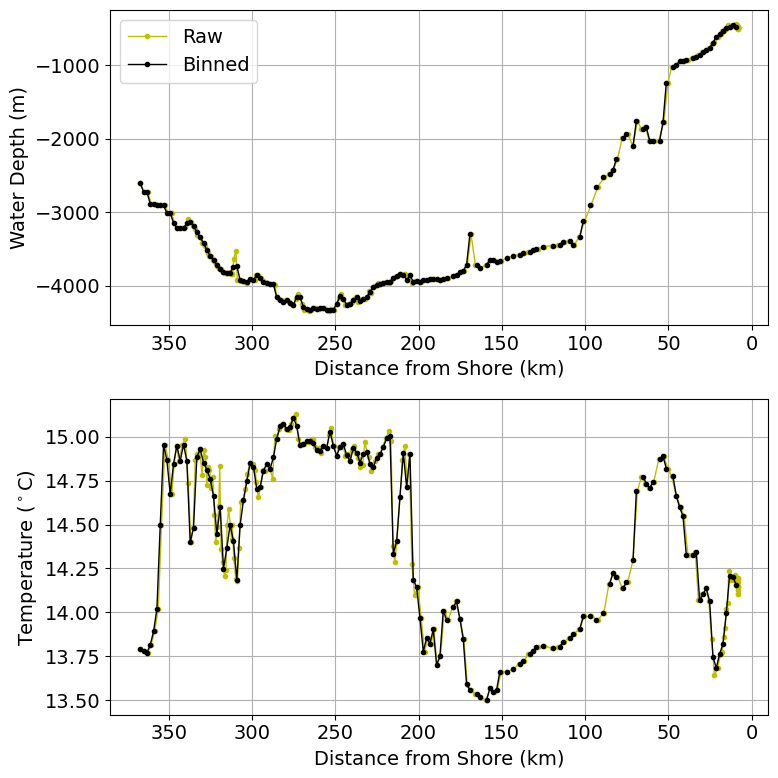

In [19]:
# Create figure
fig, axes = plt.subplots(2,1, figsize=(8, 8))

#--- Suplot #1 ---# 

# Plot interpolated water depth
axes[0].plot(dist_trans,water_depth_trans,'y.-',label=f'Raw',linewidth=1)
axes[0].plot(dist_bin,water_depth_bin,'k.-',label=f'Binned',linewidth=1)

# Set axis attributes
axes[0].set_xlabel(r"Distance from Shore (km)")
axes[0].set_ylabel(r"Water Depth (m)")
#axes[0].set_xlim(0,120)
#axes[0].set_ylim(-4000,0)
axes[0].grid()
axes[0].legend(loc='upper left', fontsize=fontsize)

# Reverse the direction of the x-axis 
axes[0].invert_xaxis()

#--- Suplot #2 ---# 

# Plot interpolated water depth
axes[1].plot(dist_trans,temp_trans,'y.-',linewidth=1)
axes[1].plot(dist_bin,temp_bin,'k.-',linewidth=1)

# Set axis attributes
axes[1].set_xlabel(r"Distance from Shore (km)")
axes[1].set_ylabel(r"Temperature ($^\circ$C)")
#axes[1].set_xlim(0,120)
#axes[1].set_ylim(11.25,13)
axes[1].grid()

# Reverse the direction of the x-axis 
axes[1].invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/water_depth_temperature_bin_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_binWidth_' + str(mean_dist_diff) + 'km' + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

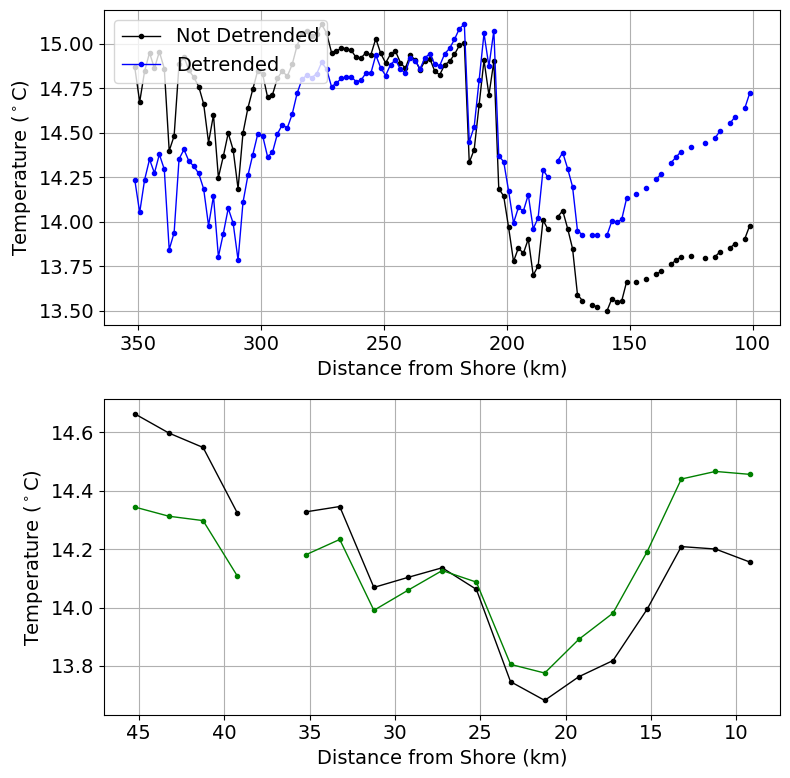

In [20]:
# Create figure
fig, axes = plt.subplots(2,1, figsize=(8, 8))

#--- Suplot #1 ---# 

# Plot detrended temperature off shelf
axes[0].plot(dist_off,temp_off,'k.-',label=f'Not Detrended',linewidth=1)
axes[0].plot(dist_off,temp_off_dt,'b.-',label=f'Detrended',linewidth=1)

# Set axis attributes
axes[0].set_xlabel(r"Distance from Shore (km)")
axes[0].set_ylabel(r"Temperature ($^\circ$C)")
#axes[0].set_xlim(75,120)
#axes[0].set_ylim(11.25,13)
axes[0].grid()
axes[0].legend(loc='upper left', fontsize=fontsize)

# Reverse the direction of the x-axis 
axes[0].invert_xaxis()

#--- Suplot #2 ---# 

# Plot interpolated water depth
axes[1].plot(dist_on,temp_on,'k.-',linewidth=1)
axes[1].plot(dist_on,temp_on_dt,'g.-',linewidth=1)

# Set axis attributes
axes[1].set_xlabel(r"Distance from Shore (km)")
axes[1].set_ylabel(r"Temperature ($^\circ$C)")
#axes[1].set_xlim(13,26)
#axes[1].set_ylim(12.5,13)
axes[1].grid()

# Reverse the direction of the x-axis 
axes[1].invert_xaxis()

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/spray_glider/Scale_analysis/water_depth_temperature_detrend_ex_'  + years_d[0] + '_to_' + years_d[-1] + '_depth_av_' + str(depth_bin) + '_binWidth_' + str(mean_dist_diff) + 'km' + '_transNum_' + str(transNum), bbox_inches = 'tight', dpi=300)

Thoughts of what I need to do right now for my analysis 
1. Interpolate the data onto a regular spatial grid. 
2. Split the data into on-shelf and off-shelf segments. 
3. Detrend the segments for SST. 
4. Compute the autocorrelation function for both segments. 

Ideas for further analysis: 
1. If I compute the autocorrelation onto the standardized spatial grid, I can split off-shelf and on-shelf transects throughout the year and create a analogous figure to a spectrogram but for the autocorrelation function to show how the autocorrelation varies throughout the year. The main thing I will need to figure out here is how to automate the transect finding procedure. If I apply the same depth criteria to the on-shelf and off-shelf regimes, then this process won't need to be automated. 
2. Playing around with the vertical averaging and the depth I am plotting. 
3. I should extend this to velocity, but I think I should first rotate my velocity vectors to be in the across-shelf/along-shelf coordinate system. 

Interpolate spatial data to a regular grid

In [21]:
# Generate a distance from shore vector
dr = 0.1 #np.diff(dist_trans)
dist_interp = np.arange(dist_trans[0],dist_trans[-1] + dr,dr)

# Create an interpolation function for temperature and water depth 
f_temp = interp1d(dist_trans, temp_trans, kind='linear',fill_value='extrapolate')  
f_water_depth = interp1d(dist_trans, water_depth_trans, kind='linear',fill_value='extrapolate')

# Use the function to get interpolated values
temp_interp = f_temp(dist_interp)
water_depth_interp = f_water_depth(dist_interp)

# Set the interpolated grids to masked arrays
dist_interp = np.ma.array(dist_interp)
temp_interp = np.ma.array(temp_interp)
water_depth_interp = np.ma.array(water_depth_interp)

**Note on interpolating before computing an autocorrelation**

Interpolation should **NOT** be preformed before computing the autocorrelation function. By interpolating your data onto a regular grid with no gaps, you are introducing data to your time series which will impact the characteristic scale of the data record. But leaving the gaps with NaNs or masked values, you care able to still compute the autocorrelation for each lag, the correlation will just be computed at all the data pairs between your data. 

In [22]:
data = np.round(temp_on,2)
window = len(temp_on)
lag = len(temp_on)
task = 'full'
bias = 'unbiased_tapered'

# Print Parameters
print(data)
print(window)
print(lag)
print(task)
print(bias)

# Choose interval length n which the correlation coefficient will be computed
N = window

# Initialize autocovariance and autocorrelation arrays
coef = np.zeros(lag)
cov = np.zeros(lag)

# Set fixed data segments
if task == 'window':
    fix = data[:N]

# Loop through each lag interval to compute the correlation and covariance    
i = 0 #len(temp_on) -3

# Set running and fixed window

#--- Full record ---# 
if task == 'full':

    # Set running data segment forwards
    running = data[i:N]
    print(i)
    print(i+N)
    print(running)

    # Set running data segment backwards
    fix = data[:N-i]
    print(N-i)
    print(fix)

    #--- Windowed record ---# 
elif task == 'window':

    # Set running data segment fowards
    ind_run_i = i * N
    ind_run_f = ind_run_i + N
    running = data[ind_run_i:ind_run_f]

# Remove mean from each segment before computing covariance and correlation
fix -= np.ma.mean(data)
running -= np.ma.mean(data)

# Compute the correlation coefficient terms at lag time i
inner_product = np.ma.dot(fix, running)

# Compute the number of data pairs (counting pairs with masked values)
n = len(running)  # Equivalent to N - i 

# Compute number of data pairs discounting pairs with masked vaules
combined_mask = np.logical_or(fix.mask, running.mask)
n_eff = np.sum(~combined_mask)

print(fix.mask)
print(running.mask)
print(~combined_mask)

# Compute autocorrelation and autocovariance

#--- Unbiased ---# 
if bias == 'unbiased':
    coef[i] = (1 / n) * inner_product / ((1 / N) * np.ma.sum((data - np.ma.mean(data))**2))
    cov[i] = (1 / n) * inner_product

if bias == 'unbiased_tapered':
    print(n_eff)
    print(n)
    print(N)
    print(1/n_eff)
    print(n/N)
    coef[i] = (1 / n_eff) * (n / N) * inner_product / ((1 / N) * np.ma.sum((data - np.ma.mean(data))**2))
    cov[i] = (1 / n_eff) * (n / N) * inner_product

#--- Biased ---# 
elif bias == 'biased':
    coef[i] = inner_product / np.ma.sum((data - np.ma.mean(data))**2)   # 1/N is in numerator and denominator, so they cancel out
    cov[i] = (1 / N) * inner_product

print(coef)

[14.16 14.2 14.21 13.99 13.82 13.76 13.68 13.75 14.06 14.14 14.1 14.07
 14.35 14.33 -- 14.32 14.55 14.6 14.66]
19
19
full
unbiased_tapered
0
19
[14.16 14.2 14.21 13.99 13.82 13.76 13.68 13.75 14.06 14.14 14.1 14.07
 14.35 14.33 -- 14.32 14.55 14.6 14.66]
19
[14.16 14.2 14.21 13.99 13.82 13.76 13.68 13.75 14.06 14.14 14.1 14.07
 14.35 14.33 -- 14.32 14.55 14.6 14.66]
[False False False False False False False False False False False False
 False False  True False False False False]
[False False False False False False False False False False False False
 False False  True False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True]
18
19
19
0.05555555555555555
1.0
[1.05555556 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [23]:
print(1/n_eff)
print(1/(N-1))

0.05555555555555555
0.05555555555555555


In [24]:
inner_product

masked_array(data=1.41456111,
             mask=False,
       fill_value=1e+20)

In [25]:
(np.ma.sum((data - np.ma.mean(data))**2))

1.4145611111111114

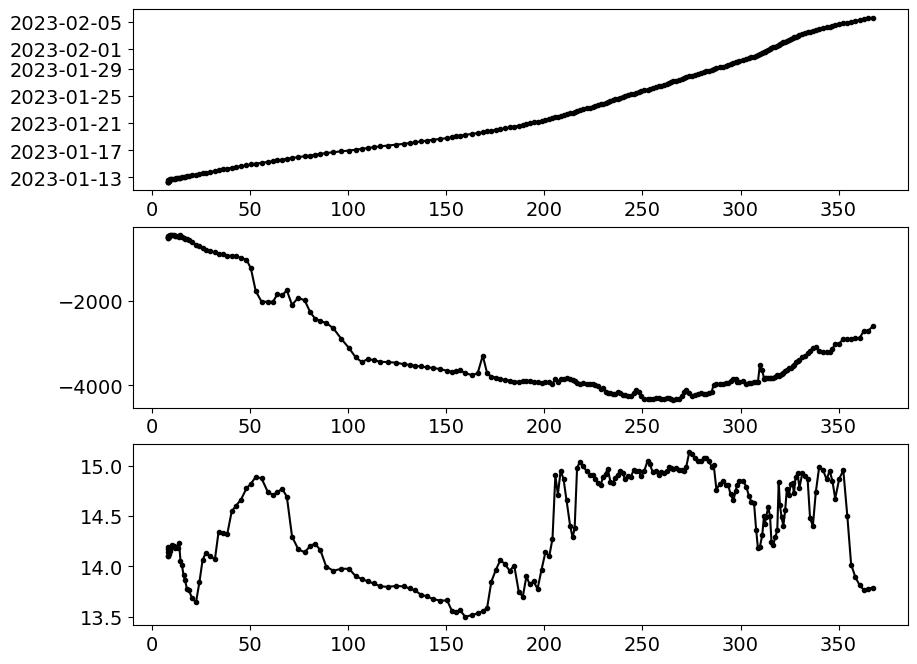

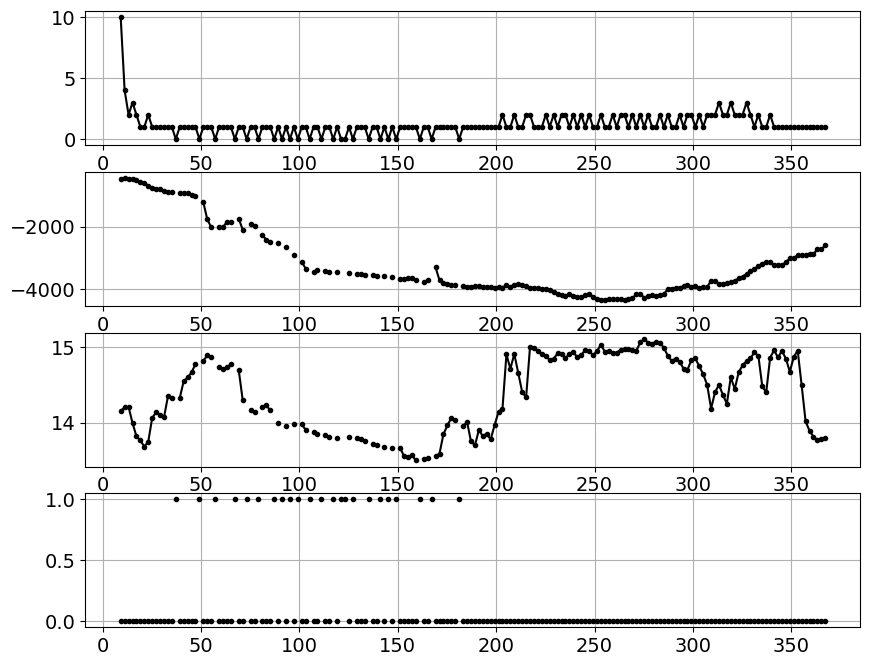

In [26]:
fig, axes = plt.subplots(3,1, figsize=(10, 8))

axes[0].plot(dist_trans,time_trans,'k.-')

axes[1].plot(dist_trans,water_depth_trans,'k.-')

axes[2].plot(dist_trans,temp_trans,'k.-')

plt.show()

fig, axes = plt.subplots(4,1, figsize=(10, 8))

axes[0].plot(dist_bin,counts,'k.-')
axes[0].grid()

axes[1].plot(dist_bin,water_depth_bin,'k.-')
axes[1].grid()

axes[2].plot(dist_bin,temp_bin,'k.-')
axes[2].grid()

axes[3].plot(dist_bin,water_depth_bin.mask,'k.')
axes[3].grid()

plt.show()

